# GreenSense: Environmental Sensing System for Optimal Plant Selection

### Predicting Crops From Analyzing Soil and Environmental Factors


## > Importing Libraries & Initial Setup

---


In [50]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, RobustScaler,
                                   MultiLabelBinarizer, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import catboost as cb
from skmultilearn.model_selection import IterativeStratification

from sklearn.metrics import (accuracy_score, hamming_loss, f1_score,
                             precision_score, recall_score, classification_report,
                             confusion_matrix, multilabel_confusion_matrix)
from sklearn.multioutput import MultiOutputClassifier

import joblib
import time

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports Done !")

Imports Done !


---
---


# > Synthetic Data Generation Based On Research Parameters

---

In [51]:
import pandas as pd
import numpy as np
import random
import math

def generate_realistic_agri_data(
    num_rows=2000,
    noise_level=0.05,
    null_fraction=0.05,
    all_null_rows_fraction=0.01,
    half_null_rows_fraction=0.02,
    anomaly_rate=0.02,
    extreme_outlier_rate=0.005,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # --- Profiles ---
    profiles = [
        {
            "district": "Raigad",
            "location": "Karjat",
            "altitude_range": (50, 65), 
            "pressure_range": (1004, 1008),
            "ph_range": (5.5, 6.0),
            "n_dist": {"mean": 270, "std": 25},  
            "p_dist": {"mean": 8, "std": 2}, 
            "k_dist": {"mean": 220, "std": 20},
            "annual_temp_range": (16, 38),  
            "base_temp": 27.5,
            "monsoon_humidity_range": (85, 98),
            "crops": ["Rice", "Ragi", "Vari", "Mango", "Cashew", "Coconut", "Green Gram"],
        },
        {
            "district": "Raigad",
            "location": "Alibag/Mangaon",
            "altitude_range": (5, 15),
            "pressure_range": (1008, 1012),
            "ph_range": (5.5, 6.2),
            "n_dist": {"mean": 285, "std": 30},
            "p_dist": {"mean": 10, "std": 3},
            "k_dist": {"mean": 230, "std": 25},
            "annual_temp_range": (18, 36), 
            "base_temp": 27,
            "monsoon_humidity_range": (90, 98),
            "crops": ["Rice", "Coconut", "Arecanut", "Mango", "Cashew", "Banana"],
        },
        {
            "district": "Nashik",
            "location": "Niphad/Yeola",
            "altitude_range": (560, 580),
            "pressure_range": (945, 955),
            "ph_range": (7.0, 7.8),
            "n_dist": {"mean": 230, "std": 25},
            "p_dist": {"mean": 25, "std": 5},  
            "k_dist": {"mean": 270, "std": 30},
            "annual_temp_range": (10, 42),
            "base_temp": 27.5,
            "monsoon_humidity_range": (70, 85),
            "crops": ["Grapes", "Onion", "Pomegranate", "Sugarcane", "Tomato", "Wheat"],
        },
        {
            "district": "Nashik",
            "location": "Baglan/Kalwan",
            "altitude_range": (450, 600),
            "pressure_range": (945, 960),
            "ph_range": (6.8, 7.5),
            "n_dist": {"mean": 220, "std": 30},
            "p_dist": {"mean": 45, "std": 8},
            "k_dist": {"mean": 250, "std": 25},
            "annual_temp_range": (14, 42),
            "base_temp": 27.5,
            "monsoon_humidity_range": (75, 90),
            "crops": ["Onion", "Maize", "Bajra", "Grapes", "Mango", "Soybean", "Groundnut"],
        },
        {
            "district": "Nashik",
            "location": "Igatpuri (Ghat Zone)",
            "altitude_range": (600, 900),
            "pressure_range": (940, 950),
            "ph_range": (6.0, 7.0),
            "n_dist": {"mean": 250, "std": 35},
            "p_dist": {"mean": 15, "std": 4},
            "k_dist": {"mean": 180, "std": 30},
            "annual_temp_range": (13, 38),
            "base_temp": 25,
            "monsoon_humidity_range": (85, 100),
            "crops": ["Rice", "Finger Millet", "Maize", "Vegetables"],
        },
    ]


    records = []
    anomaly_flags = []  

    for i in range(num_rows):
        profile = random.choice(profiles)
        day_of_year = random.randint(1, 365)

        # Seasonal temperature
        temp_amp = (profile['annual_temp_range'][1] - profile['annual_temp_range'][0]) / 2
        env_temp = profile['base_temp'] + temp_amp * math.sin(math.radians(day_of_year - 90))

        # Season
        if 60 <= day_of_year <= 150:
            season = 'Summer'
            env_humidity = np.random.uniform(20, 45)
            light_intensity = np.random.uniform(90000, 115000)
            soil_humidity = np.random.uniform(10, 30)
        elif 151 <= day_of_year <= 273:
            season = 'Monsoon'
            env_humidity = np.random.uniform(*profile['monsoon_humidity_range'])
            light_intensity = np.random.uniform(15000, 55000)
            soil_humidity = np.random.uniform(80, 98)
        else:
            season = 'Winter'
            env_humidity = np.random.uniform(40, 65)
            light_intensity = np.random.uniform(60000, 90000)
            soil_humidity = np.random.uniform(30, 55)

        # Irrigation adjustment
        irrigated_crops = ['Grapes', 'Sugarcane', 'Onion', 'Tomato', 'Wheat', 'Pomegranate']
        if profile['district'] == 'Nashik' and season != 'Monsoon' and any(c in profile['crops'] for c in irrigated_crops):
            soil_humidity = max(soil_humidity, np.random.uniform(40, 65))

        altitude = float(np.random.uniform(*profile['altitude_range']))
        pressure = float(np.random.uniform(*profile['pressure_range']))
        env_gasses_co2 = float(np.random.uniform(405, 425))
        env_pollution = float(np.random.choice([np.random.uniform(10, 25), np.random.uniform(60, 220)], p=[0.95, 0.05]))
        ph = float(np.random.uniform(*profile['ph_range']))
        N = float(np.abs(np.random.normal(profile['n_dist']['mean'], profile['n_dist']['std'])))
        P = float(np.abs(np.random.normal(profile['p_dist']['mean'], profile['p_dist']['std'])))
        K = float(np.abs(np.random.normal(profile['k_dist']['mean'], profile['k_dist']['std'])))
        soil_temp = float(env_temp - np.random.uniform(1.5, 4.0))

        record = {
            'N_kg_per_ha': N,
            'P_kg_per_ha': P,
            'K_kg_per_ha': K,
            'pH': ph,
            'soil_temp_c': soil_temp,
            'soil_humidity_percent': soil_humidity,
            'env_temp_c': env_temp,
            'env_humidity_percent': env_humidity,
            'env_pollution_ppm': env_pollution,
            'env_gasses_co2_ppm': env_gasses_co2,
            'altitude_m': altitude,
            'light_intensity_lux': light_intensity,
            'pressure_hpa': pressure,
            'district': profile['district'],
            'location': profile['location'],
            'season': season,
            'target_crops': ', '.join(profile['crops'])
        }

        # Add multiplicative noise to numeric fields
        for k in ['N_kg_per_ha','P_kg_per_ha','K_kg_per_ha','pH',
                  'soil_temp_c','soil_humidity_percent','env_temp_c','env_humidity_percent',
                  'env_pollution_ppm','env_gasses_co2_ppm','altitude_m','light_intensity_lux','pressure_hpa']:
            val = record[k]
            # small absolute noise for small values (pH)
            if abs(val) < 1:
                noise = np.random.normal(0, noise_level * 0.1)
                record[k] = float(val + noise)
            else:
                noise = np.random.normal(0, noise_level)  # fractional
                record[k] = float(val * (1 + noise))

        # Possibly inject anomaly (sensor spike or impossible negative)
        anomalous = False
        if np.random.rand() < anomaly_rate:
            anomalous = True
            # choose a numeric field to corrupt
            corrupt_field = random.choice(['env_pollution_ppm','light_intensity_lux','N_kg_per_ha','env_temp_c'])
            if corrupt_field == 'env_pollution_ppm':
                # occasional very high pollution value
                record[corrupt_field] = float(np.random.uniform(250, 2000))
            elif corrupt_field == 'light_intensity_lux':
                # impossible spike
                record[corrupt_field] = float(np.random.uniform(200000, 1000000))
            elif corrupt_field == 'N_kg_per_ha':
                # negative spike or zero (sensor mis-read)
                record[corrupt_field] = float(np.random.choice([ -abs(np.random.uniform(1, 100)), 0.0 ]))
            elif corrupt_field == 'env_temp_c':
                # unrealistic temp
                record[corrupt_field] = float(np.random.uniform(-20, 60))

        # Rare extreme outlier (very large multiplier)
        if np.random.rand() < extreme_outlier_rate:
            out_field = random.choice(['P_kg_per_ha','K_kg_per_ha','altitude_m'])
            record[out_field] = float(record[out_field] * np.random.uniform(5, 30))
            anomalous = True

        records.append(record)
        anomaly_flags.append(anomalous)

    df = pd.DataFrame(records)

    mask = np.random.rand(*df.shape) < null_fraction
    df = df.mask(mask)

    n_all_null = int(all_null_rows_fraction * num_rows)
    all_null_indices = set()
    for _ in range(n_all_null):
        idx = np.random.randint(0, len(df))
        df.iloc[idx] = np.nan
        all_null_indices.add(idx)
        anomaly_flags[idx] = False  # override anomaly flag - row is simply missing

    n_half_null = int(half_null_rows_fraction * num_rows)
    cols = df.columns.tolist()
    for _ in range(n_half_null):
        idx = np.random.randint(0, len(df))
        # select >50% columns to set to NaN (prefer numeric)
        n_to_null = max(1, int(len(cols) * 0.55))
        null_cols = list(np.random.choice(cols, size=n_to_null, replace=False))
        df.loc[idx, null_cols] = np.nan
        # if we set all columns then count as all-null
        if df.loc[idx].isna().all():
            all_null_indices.add(idx)
            anomaly_flags[idx] = False
        else:
            # keep anomaly flag as is (could be set earlier)
            pass

    flags = []
    for idx, row in df.iterrows():
        if row.isna().all():
            flags.append('all_null')
        elif row.isna().sum() / len(row) > 0.5:
            flags.append('partial_null')
        elif anomaly_flags[idx]:
            flags.append('anomalous')
        else:
            flags.append('clean')

    # df['data_quality_flag'] = flags

    numeric_cols = ['N_kg_per_ha','P_kg_per_ha','K_kg_per_ha','pH',
                    'soil_temp_c','soil_humidity_percent','env_temp_c','env_humidity_percent',
                    'env_pollution_ppm','env_gasses_co2_ppm','altitude_m','light_intensity_lux','pressure_hpa']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Reset index and return
    return df.reset_index(drop=True)



df_sample = generate_realistic_agri_data(
    num_rows=np.random.randint(22000, 30000),
    noise_level=0.07,
    null_fraction=0.06,
    all_null_rows_fraction=0.01,
    half_null_rows_fraction=0.02,
    anomaly_rate=0.04,
    extreme_outlier_rate=0.007,
    seed=42
)
print(df_sample.shape)
print(df_sample.head(10))
df_sample.to_csv("synthetic_realistic_data_noise.csv", index=False)
df = df_sample

(29270, 17)
   N_kg_per_ha  P_kg_per_ha  K_kg_per_ha        pH  soil_temp_c  \
0   249.843482     7.423648   224.750754  6.188601    12.972315   
1   216.192080    19.184976   293.317944  6.873708    30.265360   
2   308.398689    11.165168   226.023256  5.995650    23.228723   
3   266.178459    10.823312   201.749820  4.553704    15.067922   
4   229.766417    14.379096   200.205583  7.290792    13.161261   
5   303.953389     9.847660   184.131542  5.497218    34.839284   
6   231.799261     6.462315   261.745950  5.444077    16.485150   
7   282.111170     5.330471          NaN  5.900139    27.178496   
8   260.529880     8.535645   273.085563  5.538963    25.460903   
9   297.174682    23.521453   133.250224  7.170935    26.861183   

   soil_humidity_percent  env_temp_c  env_humidity_percent  env_pollution_ppm  \
0              46.852629   15.909798             46.933137           9.243029   
1              67.614604   35.514372             21.975882          19.014425   
2      

## > Data Loading

---


In [52]:
# dataset_id = "1gcT3BLkUZNoM5sTnvazYJ0ecaGaVXh1D"

# url = f"https://drive.google.com/uc?id={dataset_id}"

# df = pd.read_csv(url)
# print(f"Loaded dataframe with shape: {df.shape}")

---
---


## > Exploratory Data Analysis (EDA)

---

### > Tabular EDA

---


In [53]:
print("### Dataframe Info ###")
df.info()

### Dataframe Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29270 entries, 0 to 29269
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   N_kg_per_ha            26970 non-null  float64
 1   P_kg_per_ha            26924 non-null  float64
 2   K_kg_per_ha            26991 non-null  float64
 3   pH                     26987 non-null  float64
 4   soil_temp_c            27014 non-null  float64
 5   soil_humidity_percent  26985 non-null  float64
 6   env_temp_c             26919 non-null  float64
 7   env_humidity_percent   26986 non-null  float64
 8   env_pollution_ppm      26950 non-null  float64
 9   env_gasses_co2_ppm     26971 non-null  float64
 10  altitude_m             26944 non-null  float64
 11  light_intensity_lux    26976 non-null  float64
 12  pressure_hpa           26935 non-null  float64
 13  district               26971 non-null  object 
 14  location               26932 no

In [54]:
X_df = df.drop(columns=["target_crops"])
y_df = df["target_crops"]

print("\n### Descriptive Statistics for Features ###")
X_df.describe().T


### Descriptive Statistics for Features ###


,count,mean,std,min,25%,50%,75%,max
N_kg_per_ha,26970.0,248.590964,49.758611,-99.600034,220.891854,249.597511,279.128240,416.225741
P_kg_per_ha,26924.0,21.576538,26.325226,0.291743,9.382848,15.253087,28.844785,1227.729558
K_kg_per_ha,26991.0,240.967852,234.930453,63.259915,202.126860,229.900284,258.915509,8288.528389
pH,26987.0,6.526947,0.834241,4.077784,5.864744,6.473675,7.165352,9.541132
soil_temp_c,27014.0,23.939506,9.360751,6.538484,15.611480,23.762852,31.924023,49.029290
soil_humidity_percent,26985.0,57.636356,25.708744,7.891376,39.528566,52.731321,83.356257,118.398287
env_temp_c,26919.0,26.598438,9.582770,-19.985611,18.356842,26.332767,34.678782,59.916494
env_humidity_percent,26986.0,59.320816,23.290591,16.183244,41.473645,54.814637,81.053898,124.636553
env_pollution_ppm,26950.0,34.269491,122.236107,7.913468,13.939055,17.868240,21.860413,1998.691687
env_gasses_co2_ppm,26971.0,415.046997,29.597102,303.092525,395.003056,414.920678,435.044659,531.907384


In [55]:
print("\n### Missing Values Counts ###")
print(X_df.isnull().sum())


### Missing Values Counts ###
N_kg_per_ha              2300
P_kg_per_ha              2346
K_kg_per_ha              2279
pH                       2283
soil_temp_c              2256
soil_humidity_percent    2285
env_temp_c               2351
env_humidity_percent     2284
env_pollution_ppm        2320
env_gasses_co2_ppm       2299
altitude_m               2326
light_intensity_lux      2294
pressure_hpa             2335
district                 2299
location                 2338
season                   2324
dtype: int64


### > Graphical EDA

---


In [56]:
numeric_cols = ['N_kg_per_ha', 'P_kg_per_ha', 'K_kg_per_ha', 'pH', 'soil_temp_c', 'soil_humidity_percent',
                'env_temp_c', 'env_humidity_percent', 'env_pollution_ppm', 'env_gasses_co2_ppm',
                'altitude_m', 'light_intensity_lux', 'pressure_hpa']
cat_cols = [c for c in df.columns if c not in numeric_cols]

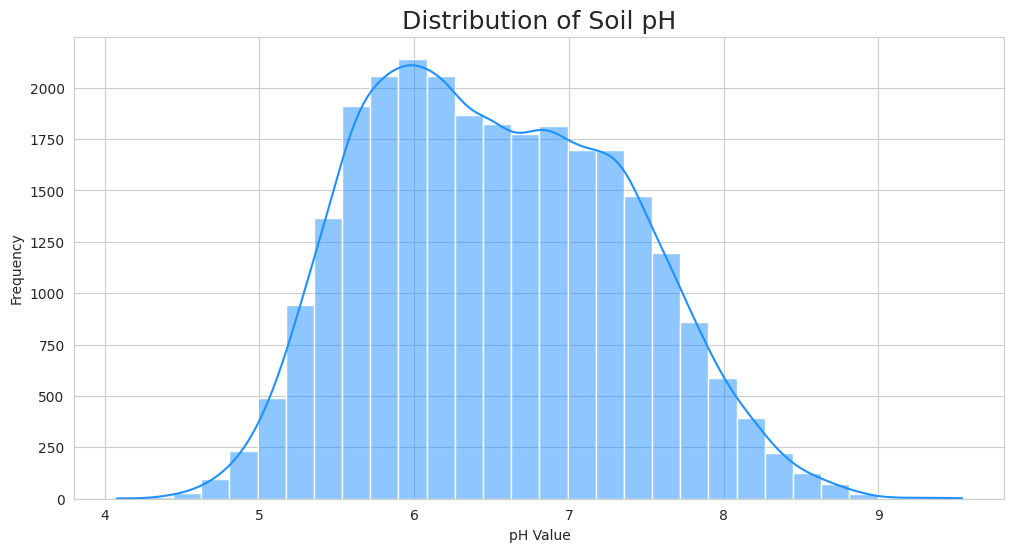

In [57]:
# Graph 1: Distribution of a Key Numerical Feature (e.g., pH)
plt.figure(figsize=(12, 6))
sns.histplot(df['pH'].dropna(), kde=True, bins=30, color='dodgerblue')
plt.title('Distribution of Soil pH', fontsize=18)
plt.xlabel('pH Value')
plt.ylabel('Frequency')
plt.show()

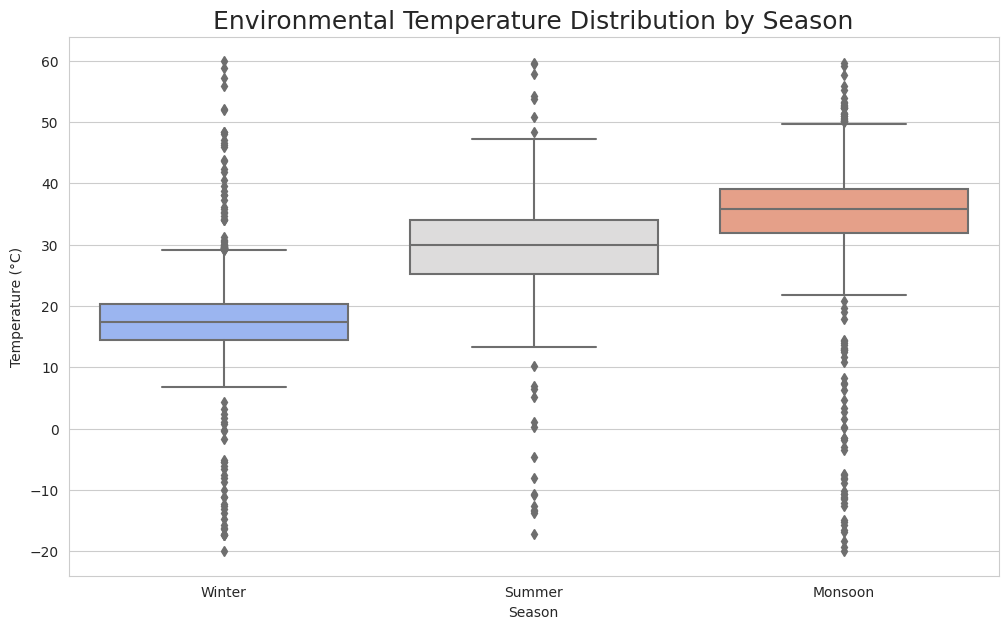

In [58]:
# Graph 2: Distribution of Environmental Temperature by Season
plt.figure(figsize=(12, 7))
sns.boxplot(x='season', y='env_temp_c', data=df, palette='coolwarm')
plt.title('Environmental Temperature Distribution by Season', fontsize=18)
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
plt.show()

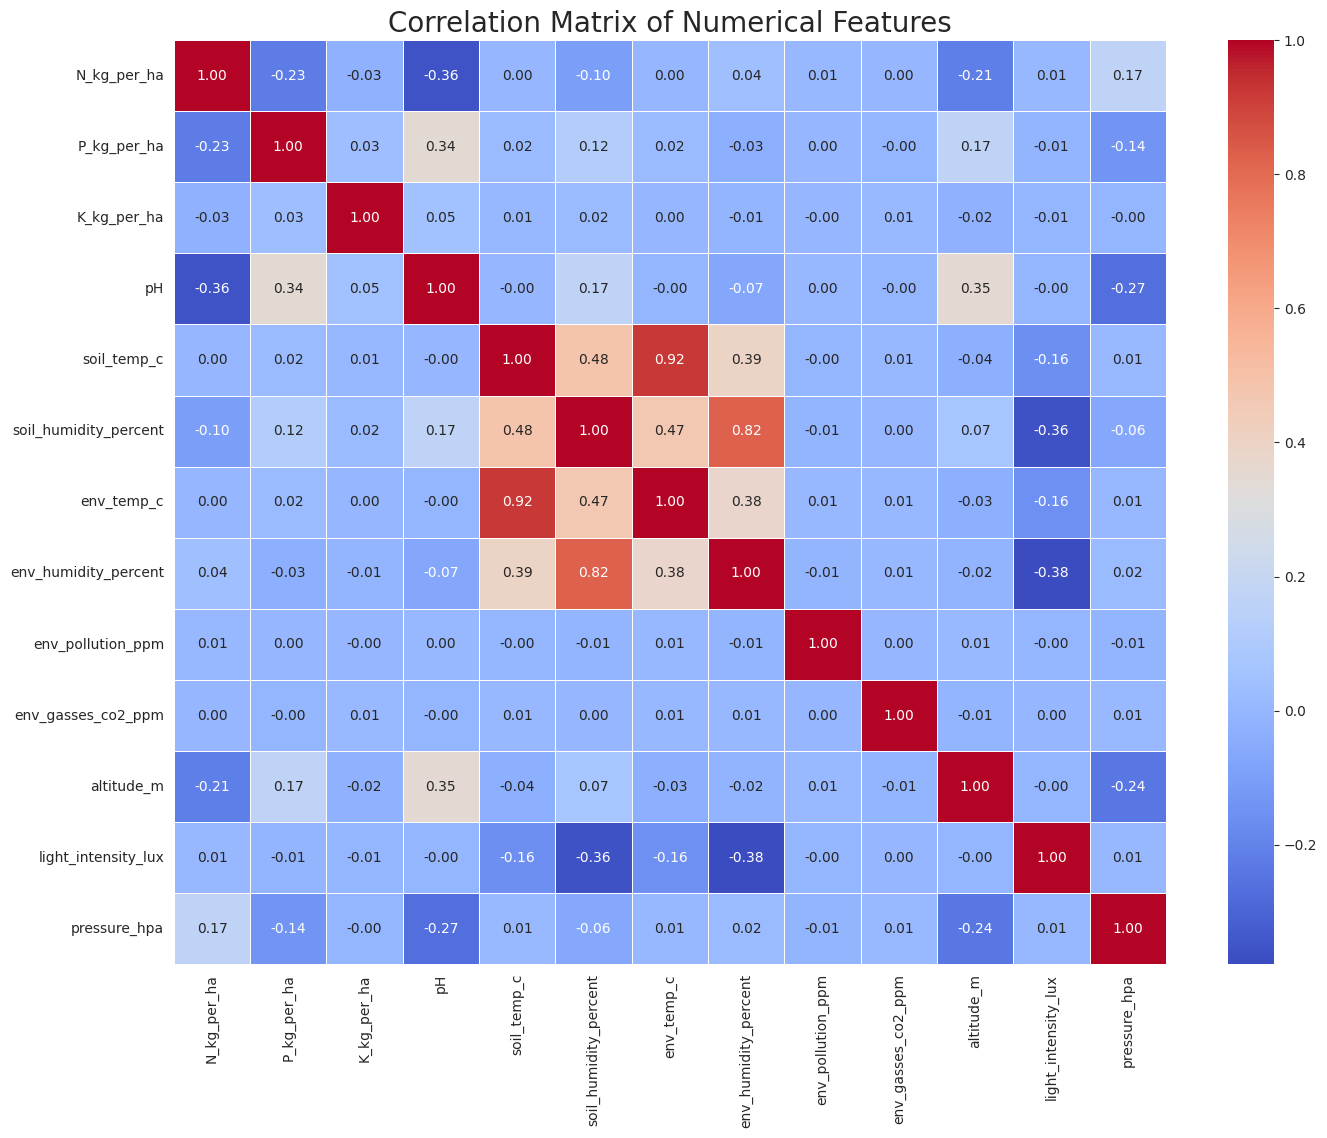

In [59]:
# Graph 3: Correlation Heatmap of Numerical Features
plt.figure(figsize=(16, 12))
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=20)
plt.show()

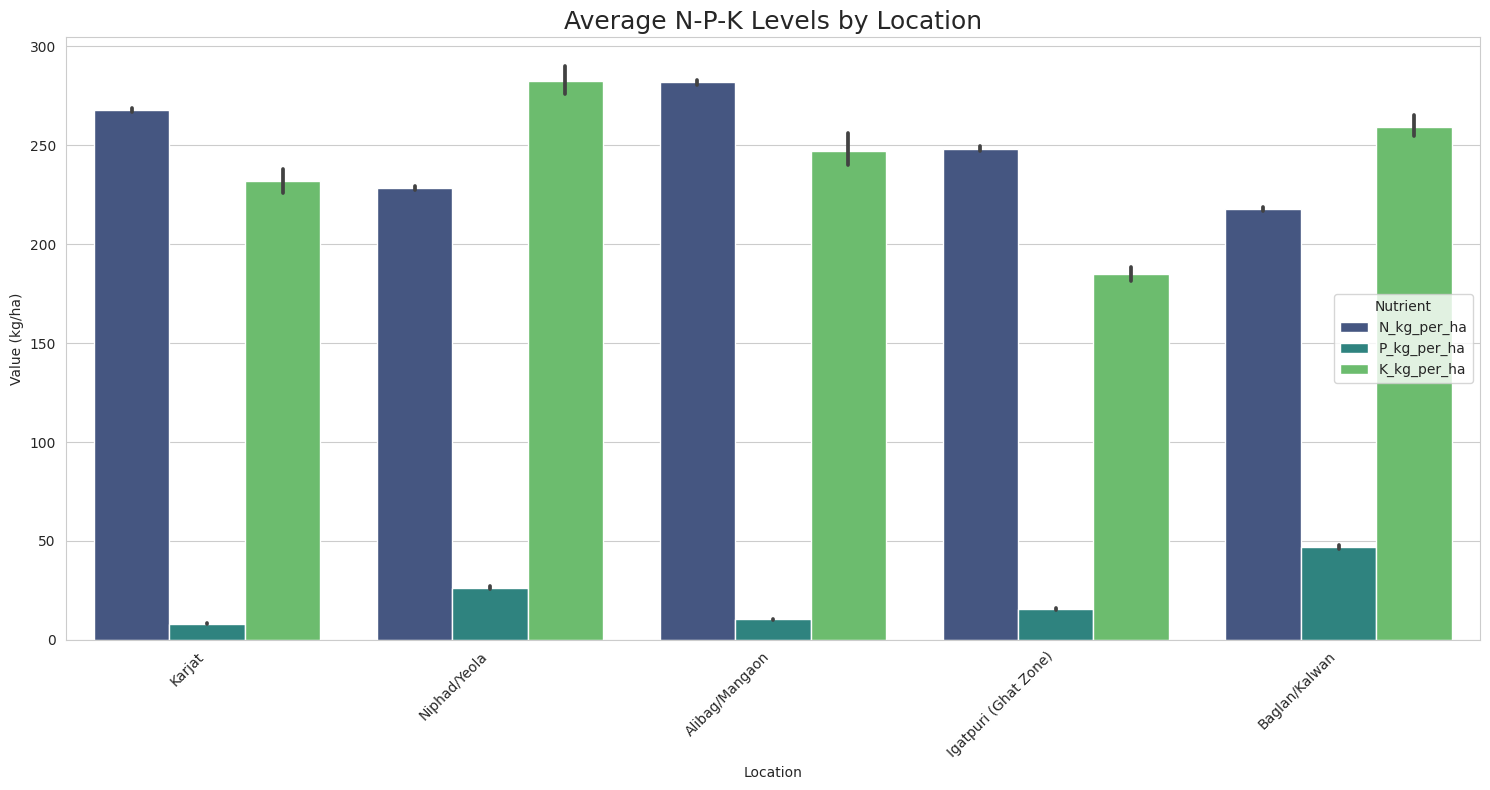

In [60]:
# Graph 4: N, P, K values by Location
plt.figure(figsize=(15, 8))
df_melted = df.melt(id_vars='location', value_vars=['N_kg_per_ha', 'P_kg_per_ha', 'K_kg_per_ha'],
                    var_name='Nutrient', value_name='Value')
sns.barplot(x='location', y='Value', hue='Nutrient',
            data=df_melted, palette='viridis')
plt.title('Average N-P-K Levels by Location', fontsize=18)
plt.xlabel('Location')
plt.ylabel('Value (kg/ha)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

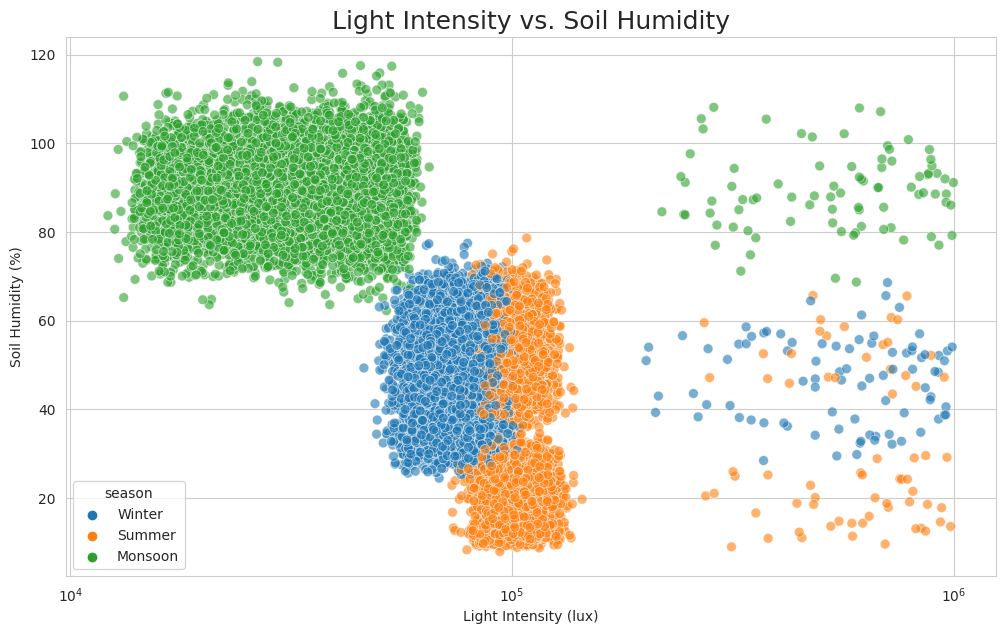

In [61]:
# Graph 5: Light Intensity vs. Soil Humidity
plt.figure(figsize=(12, 7))
sns.scatterplot(x='light_intensity_lux', y='soil_humidity_percent',
                data=df, hue='season', alpha=0.6, s=50)
plt.title('Light Intensity vs. Soil Humidity', fontsize=18)
plt.xlabel('Light Intensity (lux)')
plt.ylabel('Soil Humidity (%)')
plt.xscale('log')  # Use log scale for better visualization of lux
plt.show()

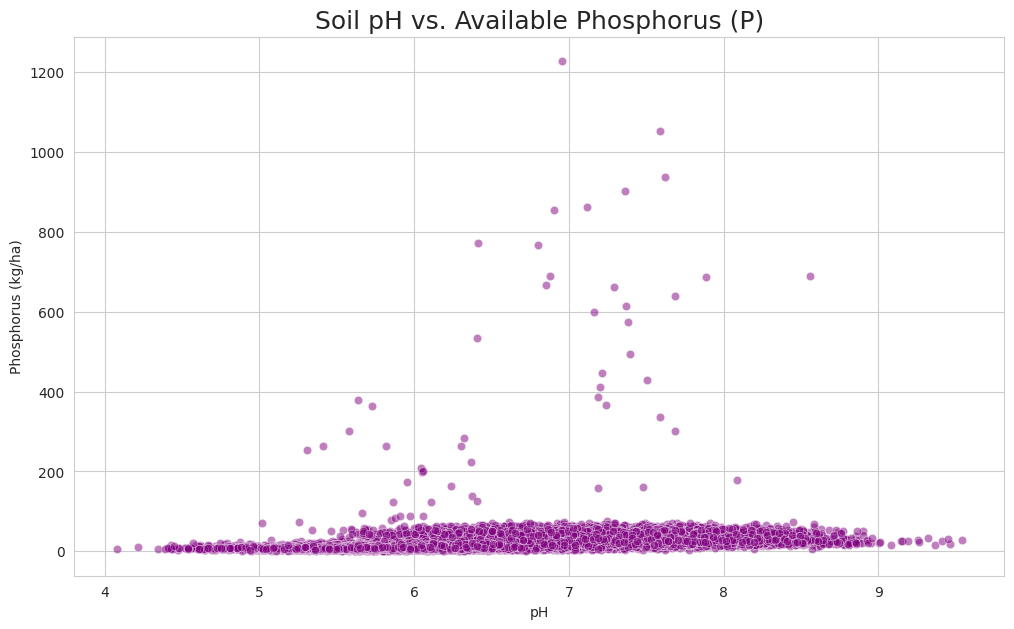

In [62]:
# Graph 7: pH vs. N-P-K Availability (showing one nutrient)
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='pH', y='P_kg_per_ha', alpha=0.5, color='purple')
plt.title('Soil pH vs. Available Phosphorus (P)', fontsize=18)
plt.xlabel('pH')
plt.ylabel('Phosphorus (kg/ha)')
plt.show()

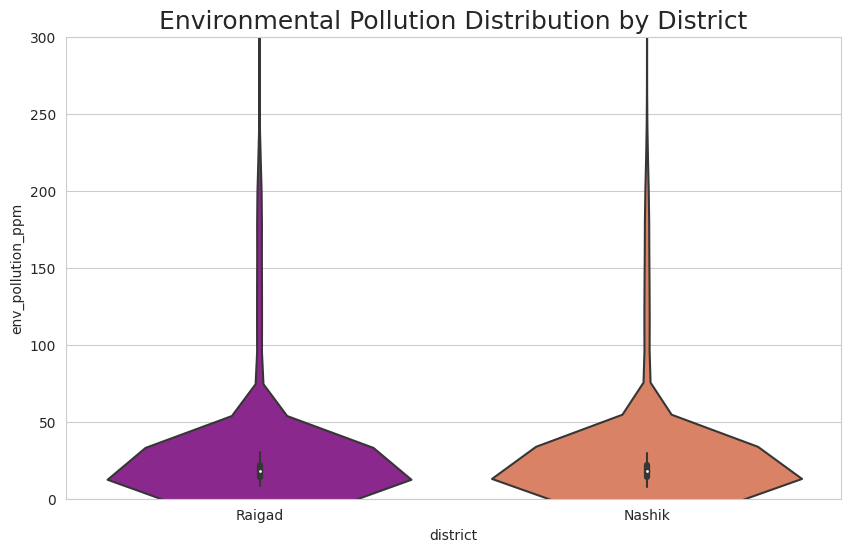

In [63]:
# Graph 8: Pollution Levels by District
plt.figure(figsize=(10, 6))
sns.violinplot(x='district', y='env_pollution_ppm', data=df, palette='plasma')
plt.title('Environmental Pollution Distribution by District', fontsize=18)
plt.ylim(0, 300)  # Cap y-axis to focus on the main distribution
plt.show()

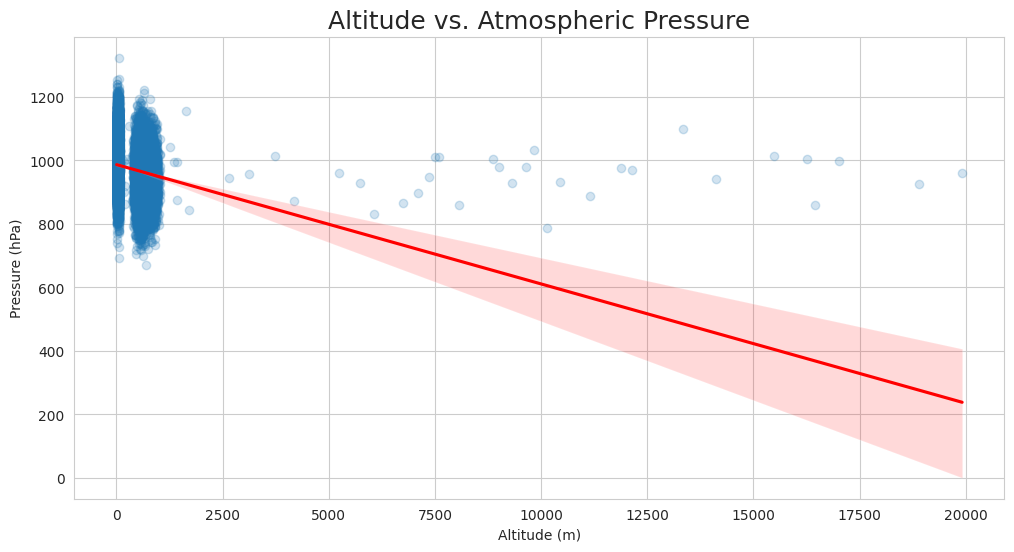

In [64]:
# Graph 9: Altitude vs. Pressure
plt.figure(figsize=(12, 6))
sns.regplot(x='altitude_m', y='pressure_hpa', data=df,
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'})
plt.title('Altitude vs. Atmospheric Pressure', fontsize=18)
plt.xlabel('Altitude (m)')
plt.ylabel('Pressure (hPa)')
plt.show()

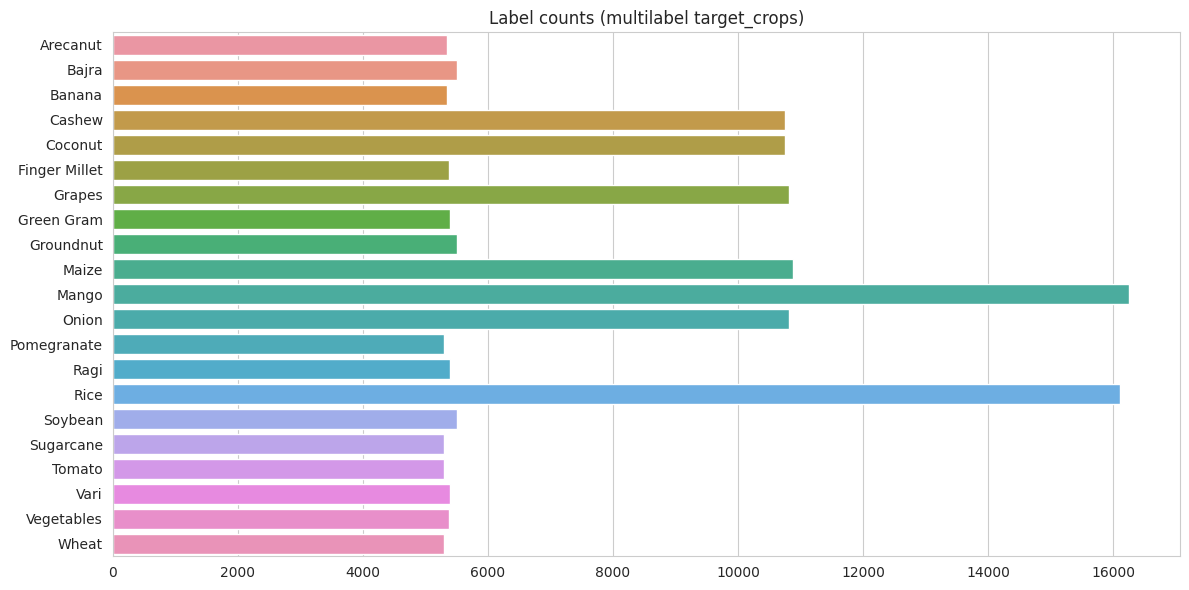

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df['target_crops'].dropna().astype(str).apply(
    lambda x: [s.strip() for s in x.split(',')])
ymat = mlb.fit_transform(labels)
counts = ymat.sum(axis=0)
plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=mlb.classes_)
plt.title('Label counts (multilabel target_crops)')
plt.tight_layout()
plt.show()

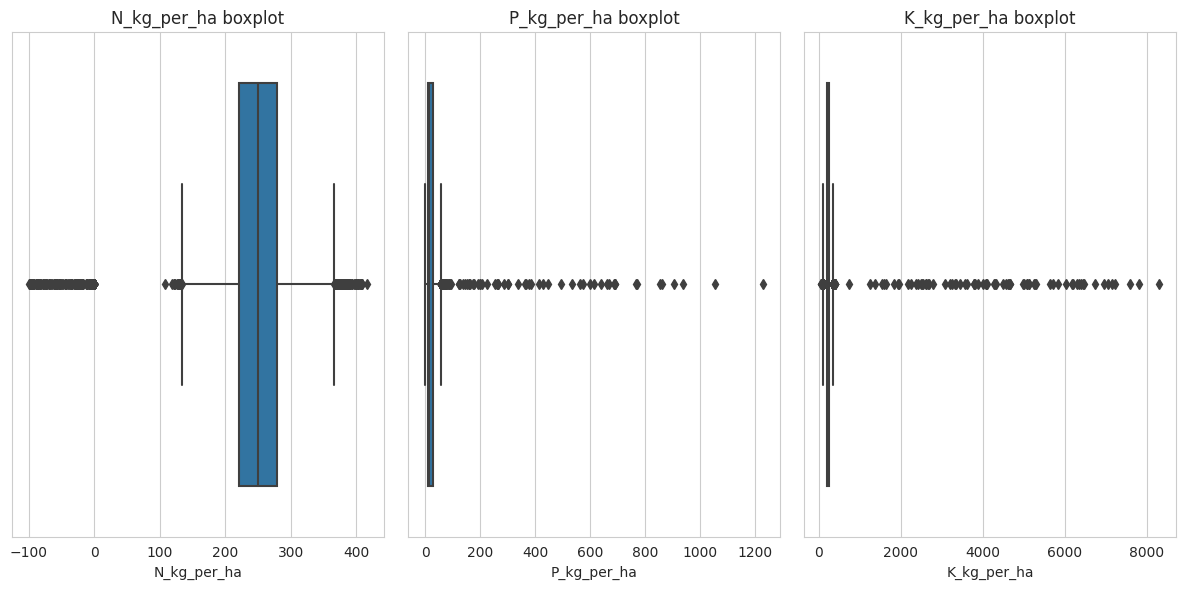

In [66]:
# 2. Boxplots to inspect outliers (N,P,K,pH)
plt.figure(figsize=(12, 6))
for i, col in enumerate(['N_kg_per_ha', 'P_kg_per_ha', 'K_kg_per_ha']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col+' boxplot')
plt.tight_layout()
plt.show()

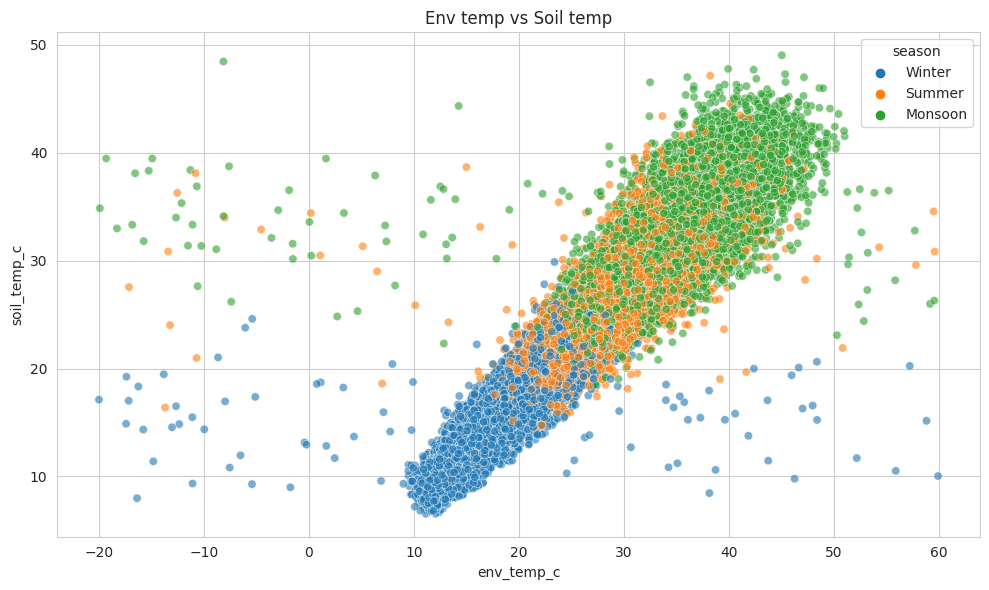

In [67]:
# 4. Scatter plot env_temp vs soil_temp (with season coloring if available)
sns.scatterplot(x='env_temp_c', y='soil_temp_c', hue='season',
                data=df, palette='tab10', alpha=0.6)
plt.title('Env temp vs Soil temp')
plt.tight_layout()
plt.show()

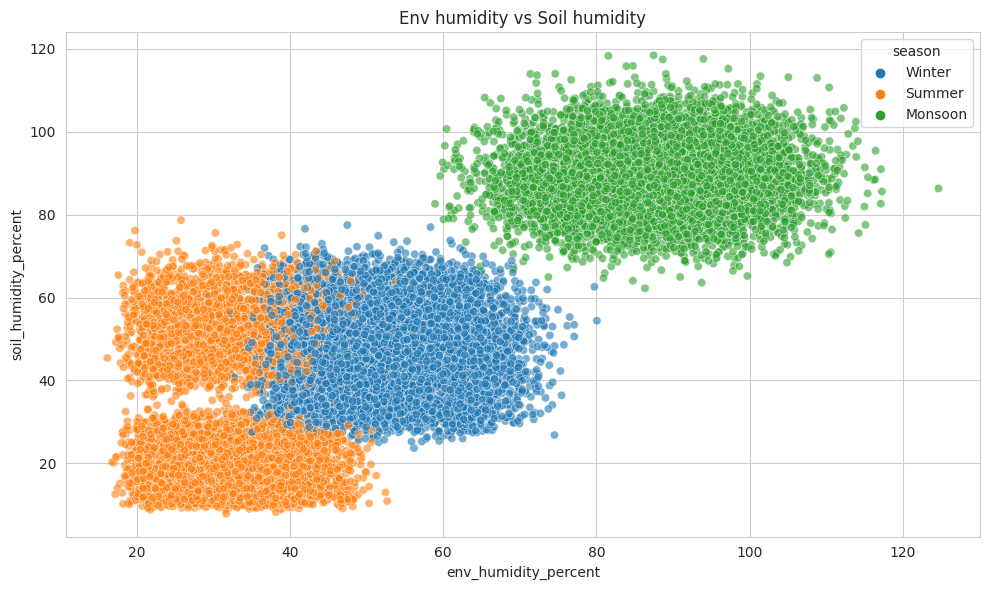

In [68]:
# 5. Scatter plot env_humidity vs soil_humidity
sns.scatterplot(x='env_humidity_percent',
                y='soil_humidity_percent', hue='season', data=df, alpha=0.6)
plt.title('Env humidity vs Soil humidity')
plt.tight_layout()
plt.show()

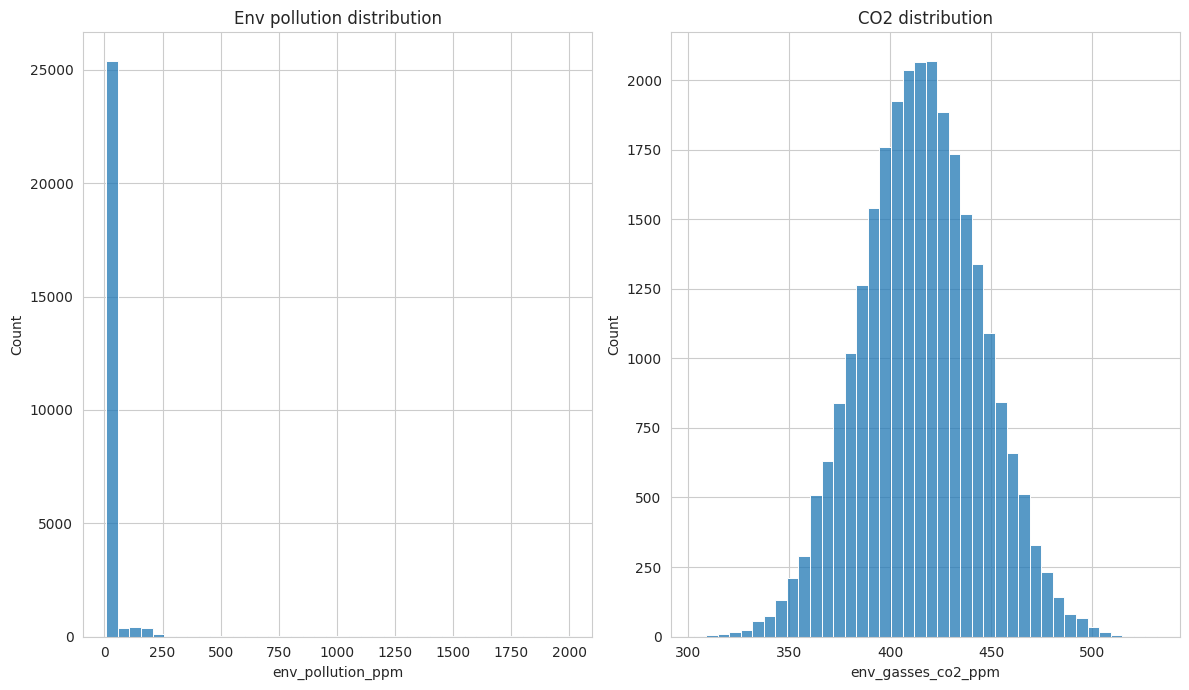

In [69]:
# 7. Distribution of env_pollution and env_gasses_co2
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
sns.histplot(df['env_pollution_ppm'].dropna(), bins=40)
plt.title('Env pollution distribution')
plt.subplot(1, 2, 2)
sns.histplot(df['env_gasses_co2_ppm'].dropna(), bins=40)
plt.title('CO2 distribution')
plt.tight_layout()
plt.show()

---
---


## > Data Cleaning

---


In [70]:
def clean_and_clip(df_in):
    df = df_in.copy()

    df.loc[df['N_kg_per_ha'] < 0, 'N_kg_per_ha'] = np.nan
    df.loc[df['env_temp_c'] < 0, 'env_temp_c'] = np.nan
    df.loc[df['env_humidity_percent'] > 100, 'env_humidity_percent'] = np.nan

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan

    return df

In [71]:
class RobustLocationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols=None, min_group_size=5, verbose=False):
        self.numeric_cols = numeric_cols
        self.min_group_size = min_group_size
        self.verbose = verbose

    def fit(self, X, y=None):
        df = X.copy()
        if self.numeric_cols is None:
            self.numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        # Compute medians for each level
        self.group_medians_ = (
            df.groupby(["district", "location", "season"])[self.numeric_cols]
            .median(numeric_only=True)
            .dropna(how="all")
        )
        self.district_medians_ = (
            df.groupby("district")[self.numeric_cols]
            .median(numeric_only=True)
            .dropna(how="all")
        )
        self.global_medians_ = df[self.numeric_cols].median(numeric_only=True)
        return self

    def set_output(self, transform=None):
        return self
        
    def transform(self, X):
        df = X.copy()
        for idx, row in df.iterrows():
            d, l, s = row["district"], row["location"], row["season"]
            group_key = (d, l, s)
            if group_key in self.group_medians_.index:
                group_valid = (
                    len(df[(df["district"] == d) & (df["location"] == l) & (df["season"] == s)])
                    >= self.min_group_size
                )
            else:
                group_valid = False
            for col in self.numeric_cols:
                if pd.isna(row[col]):
                    new_val = None
                    if group_valid and not pd.isna(self.group_medians_.loc[group_key, col]):
                        new_val = self.group_medians_.loc[group_key, col]
                    elif d in self.district_medians_.index and not pd.isna(self.district_medians_.loc[d, col]):
                        new_val = self.district_medians_.loc[d, col]
                    else:
                        new_val = self.global_medians_[col]
                    df.at[idx, col] = new_val
        return df

---
---


## > Feature Engineering

---


In [72]:
def feature_engineer(df_in):
    """Add engineered features and return a new DataFrame copy."""
    df = df_in.copy()

    df['N_plus_P'] = df['N_kg_per_ha'] + df['P_kg_per_ha']
    df['P_over_N'] = df['P_kg_per_ha'] / (df['N_kg_per_ha'] + 1e-6)
    df['K_over_N'] = df['K_kg_per_ha'] / (df['N_kg_per_ha'] + 1e-6)

    df['env_minus_soil_temp'] = df['env_temp_c'] - df['soil_temp_c']
    df['env_minus_soil_humidity'] = df['env_humidity_percent'] - \
        df['soil_humidity_percent']

    df['env_pollution_log'] = np.log1p(df['env_pollution_ppm'])
    df['light_log'] = np.log1p(df['light_intensity_lux'])

    df['alt_bucket'] = pd.cut(df['altitude_m'], bins=[-1, 100, 300, 600, 1000, 5000],
                              labels=['very_low', 'low', 'med', 'high', 'very_high'])

    season_map = {s.lower(): i for i, s in enumerate(
        ['summer', 'monsoon', 'winter', 'spring', 'autumn'])}
    df['season_enc'] = df['season'].astype(str).str.lower().map(season_map)

    return df

---
---


## > Data Preprocessing

---


In [73]:
clean_transformer = FunctionTransformer(clean_and_clip, validate=False)
impute_transformer = RobustLocationImputer(verbose=True)
fe_transformer = FunctionTransformer(feature_engineer, validate=False)

df_tmp = feature_engineer(clean_and_clip(df.copy()))

all_numeric = df_tmp.select_dtypes(
    include=['float64', 'int64', 'float32', 'int32']).columns.tolist()
all_categorical = df_tmp.select_dtypes(
    include=['object', 'category']).columns.tolist()

if 'target_crops' in all_categorical:
    all_categorical.remove('target_crops')

print('Numeric features:', all_numeric)
print('Categorical features:', all_categorical)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

ct = ColumnTransformer(transformers=[
    ('num', numeric_transformer, all_numeric),
    ('cat', categorical_transformer, all_categorical)
], remainder='drop')

preprocessor = Pipeline(steps=[
    ('cleaning', clean_transformer),
    ('robust_impute', impute_transformer),
    ('feature_engineering', fe_transformer),
    ('preprocessor', ct)
]).set_output(transform='pandas')

print("Pipeline created")

Numeric features: ['N_kg_per_ha', 'P_kg_per_ha', 'K_kg_per_ha', 'pH', 'soil_temp_c', 'soil_humidity_percent', 'env_temp_c', 'env_humidity_percent', 'env_pollution_ppm', 'env_gasses_co2_ppm', 'altitude_m', 'light_intensity_lux', 'pressure_hpa', 'N_plus_P', 'P_over_N', 'K_over_N', 'env_minus_soil_temp', 'env_minus_soil_humidity', 'env_pollution_log', 'light_log', 'season_enc']
Categorical features: ['district', 'location', 'season', 'alt_bucket']
Pipeline created


In [74]:
raw_target = df['target_crops']

mlb = MultiLabelBinarizer()
parsed = raw_target.fillna('').astype(str).apply(
    lambda x: [s.strip() for s in x.split(',') if s.strip() != ''])
Y = mlb.fit_transform(parsed)

target_classes = list(mlb.classes_)


joblib.dump(mlb, f"MLB.joblib")
print(f"Multilabel Binarizer saved as MLB.joblib")

print('Multilabel detected with classes:', target_classes)

Multilabel Binarizer saved as MLB.joblib
Multilabel detected with classes: ['Arecanut', 'Bajra', 'Banana', 'Cashew', 'Coconut', 'Finger Millet', 'Grapes', 'Green Gram', 'Groundnut', 'Maize', 'Mango', 'Onion', 'Pomegranate', 'Ragi', 'Rice', 'Soybean', 'Sugarcane', 'Tomato', 'Vari', 'Vegetables', 'Wheat']


---
---


## > Train Test Split

---


In [75]:
X = df.drop(columns=['target_crops'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)

print('Train / test shapes:', X_train.shape, X_test.shape)

Train / test shapes: (23416, 16) (5854, 16)


---
---


## > Pipeline Transformation

---


In [76]:
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

joblib.dump(preprocessor, f"preprocessing_pipeline.joblib")
print(f"Pipeline saved as preprocessing_pipeline.joblib")

print('Train / test shapes:', X_train_trans.shape, X_test_trans.shape)

Pipeline saved as preprocessing_pipeline.joblib
Train / test shapes: (23416, 36) (5854, 36)


---
---


## > Model Training

---


In [77]:
train_results = []
print("Training Logistic Regression...")
lr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000), n_jobs=-1)
lr_model.fit(X_train_trans, Y_train)

y_pred_train_lr = lr_model.predict(X_train_trans)

lr_train_metrics = {
    'Model': 'LogisticRegression',
    'F1_micro': f1_score(Y_train, y_pred_train_lr, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_lr, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_lr),
    'Accuracy': accuracy_score(Y_train, y_pred_train_lr),
    'Precision': precision_score(Y_train, y_pred_train_lr, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_lr, average='micro')
}
train_results.append(lr_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_lr))

Training Logistic Regression...


In [78]:
print("Training Decision Tree...")
dt_model = MultiOutputClassifier(DecisionTreeClassifier(), n_jobs=-1)
dt_model.fit(X_train_trans, Y_train)

y_pred_train_dt = dt_model.predict(X_train_trans)

dt_train_metrics = {
    'Model': 'DecisionTreeClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_dt, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_dt, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_dt),
    'Accuracy': accuracy_score(Y_train, y_pred_train_dt),
    'Precision': precision_score(Y_train, y_pred_train_dt, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_dt, average='micro')
}
train_results.append(dt_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_dt))

Training Decision Tree...


In [79]:
print("Training Random Forest...")
rfr_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=500, n_jobs=-1), n_jobs=-1)
rfr_model.fit(X_train_trans, Y_train)

y_pred_train_rfr = rfr_model.predict(X_train_trans)

rfr_train_metrics = {
    'Model': 'RandomForestClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_rfr, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_rfr, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_rfr),
    'Accuracy': accuracy_score(Y_train, y_pred_train_rfr),
    'Precision': precision_score(Y_train, y_pred_train_rfr, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_rfr, average='micro')
}
train_results.append(rfr_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_rfr))

Training Random Forest...


KeyboardInterrupt: 

In [ ]:
print("Training Gradient Boosting...")
gb_model = MultiOutputClassifier(
    GradientBoostingClassifier(n_estimators=500), n_jobs=-1)
gb_model.fit(X_train_trans, Y_train)

y_pred_train_gb = gb_model.predict(X_train_trans)

gb_train_metrics = {
    'Model': 'GradientBoostingClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_gb, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_gb, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_gb),
    'Accuracy': accuracy_score(Y_train, y_pred_train_gb),
    'Precision': precision_score(Y_train, y_pred_train_gb, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_gb, average='micro')
}
train_results.append(gb_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_gb))

In [ ]:
print("Training AdaBoost Classifier...")
adb_model = MultiOutputClassifier(
    AdaBoostClassifier(n_estimators=500), n_jobs=-1)
adb_model.fit(X_train_trans, Y_train)

y_pred_train_adb = adb_model.predict(X_train_trans)

adb_train_metrics = {
    'Model': 'AdaBoostClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_adb, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_adb, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_adb),
    'Accuracy': accuracy_score(Y_train, y_pred_train_adb),
    'Precision': precision_score(Y_train, y_pred_train_adb, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_adb, average='micro')
}
train_results.append(adb_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_adb))

In [ ]:
print("Training K-Neighbors Classifier...")
knn_model = MultiOutputClassifier(
    KNeighborsClassifier(n_neighbors=7), n_jobs=-1)
knn_model.fit(X_train_trans, Y_train)

y_pred_train_knn = knn_model.predict(X_train_trans)

knn_train_metrics = {
    'Model': 'KNeighborsClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_knn, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_knn, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_knn),
    'Accuracy': accuracy_score(Y_train, y_pred_train_knn),
    'Precision': precision_score(Y_train, y_pred_train_knn, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_knn, average='micro')
}
train_results.append(knn_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_knn))

In [ ]:
print("Training Support Vector Machine...")
svc_model = MultiOutputClassifier(SVC(probability=True), n_jobs=-1)
svc_model.fit(X_train_trans, Y_train)

y_pred_train_svc = svc_model.predict(X_train_trans)

svc_train_metrics = {
    'Model': 'SVC',
    'F1_micro': f1_score(Y_train, y_pred_train_svc, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_svc, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_svc),
    'Accuracy': accuracy_score(Y_train, y_pred_train_svc),
    'Precision': precision_score(Y_train, y_pred_train_svc, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_svc, average='micro')
}
train_results.append(svc_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_svc))

In [80]:
print("Training XGBClassifier...")
xgb_model = MultiOutputClassifier(
    XGBClassifier(n_estimators=500, n_jobs=-1), n_jobs=-1)
xgb_model.fit(X_train_trans, Y_train)

y_pred_train_xgb = xgb_model.predict(X_train_trans)

xgb_train_metrics = {
    'Model': 'XGBClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_xgb, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_xgb, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_xgb),
    'Accuracy': accuracy_score(Y_train, y_pred_train_xgb),
    'Precision': precision_score(Y_train, y_pred_train_xgb, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_xgb, average='micro')
}
train_results.append(xgb_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_xgb))

Training XGBClassifier...


In [ ]:
print("Training LGBMClassifier...")
lgbm_model = MultiOutputClassifier(LGBMClassifier(
    n_estimators=500, n_jobs=-1, verbosity=-1), n_jobs=-1)
lgbm_model.fit(X_train_trans, Y_train)

y_pred_train_lgbm = lgbm_model.predict(X_train_trans)

lgbm_train_metrics = {
    'Model': 'LGBMClassifier',
    'F1_micro': f1_score(Y_train, y_pred_train_lr, average='micro'),
    'F1_macro': f1_score(Y_train, y_pred_train_lr, average='macro'),
    'Hamming': hamming_loss(Y_train, y_pred_train_lr),
    'Accuracy': accuracy_score(Y_train, y_pred_train_lr),
    'Precision': precision_score(Y_train, y_pred_train_lr, average='micro'),
    'Recall': recall_score(Y_train, y_pred_train_lr, average='micro')
}
train_results.append(lgbm_train_metrics)
# print("Multilabel Confusion Matrix:")
# print(multilabel_confusion_matrix(Y_train, y_pred_train_lgbm))

In [81]:
print("\n==== TRAINING PERFORMANCE ====")
df_train_results = pd.DataFrame(train_results)
df_train_results


==== TRAINING PERFORMANCE ====


,Model,F1_micro,F1_macro,Hamming,Accuracy,Precision,Recall
0,LogisticRegression,0.952212,0.949365,0.025868,0.897933,0.927249,0.978557
1,DecisionTreeClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
2,XGBClassifier,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


---
---


## > Model Testing

---


In [83]:
test_results = []
name = 'LogisticRegression'
print(f"\nTesting {name}...")

y_pred_test = lr_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)


Testing LogisticRegression...


In [ ]:
name = 'DecisionTreeClassifier'
print(f"\nTesting {name}...")

y_pred_test = dt_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [ ]:
name = 'RandomForestClassifier'
print(f"\nTesting {name}...")

y_pred_test = rfr_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [ ]:
name = 'GradientBoostingClassifier'
print(f"\nTesting {name}...")

y_pred_test = gb_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [ ]:
name = 'AdaBoostClassifier'
print(f"\nTesting {name}...")

y_pred_test = adb_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [ ]:
name = 'KNeighborsClassifier'
print(f"\nTesting {name}...")

y_pred_test = knn_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [ ]:
name = 'SVC'
print(f"\nTesting {name}...")

y_pred_test = svc_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [84]:
name = 'XGBClassifier'
print(f"\nTesting {name}...")

y_pred_test = xgb_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)


Testing XGBClassifier...


In [ ]:
name = 'LGBMClassifier'
print(f"\nTesting {name}...")

y_pred_test = lgbm_model.predict(X_test_trans)

test_metrics = {
    'Model': name,
    'F1_micro': f1_score(Y_test, y_pred_test, average='micro'),
    'F1_macro': f1_score(Y_test, y_pred_test, average='macro'),
    'Hamming': hamming_loss(Y_test, y_pred_test),
    'Accuracy': accuracy_score(Y_test, y_pred_test),
    'Precision': precision_score(Y_test, y_pred_test, average='micro'),
    'Recall': recall_score(Y_test, y_pred_test, average='micro'),
    'Confusion Matrix': multilabel_confusion_matrix(Y_test, y_pred_test),
}
test_results.append(test_metrics)

In [85]:
print("\n==== TEST PERFORMANCE ====")
df_test_results = pd.DataFrame(test_results)
df_test_results


==== TEST PERFORMANCE ====


,Model,F1_micro,F1_macro,Hamming,Accuracy,Precision,Recall,Confusion Matrix
0,LogisticRegression,0.948843,0.946177,0.027633,0.89204,0.921167,0.978233,"[[[4732, 87], [25, 1010]], [[4610, 132], [26, ..."
1,XGBClassifier,0.954531,0.953499,0.024623,0.90451,0.924467,0.986617,"[[[4741, 78], [4, 1031]], [[4627, 115], [29, 1..."


---
---


## > Performance Measure

---


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_train_results['Model'], df_train_results['Accuracy'],
         marker='o', label='Train Accuracy')
plt.plot(df_test_results['Model'], df_test_results['Accuracy'],
         marker='o', label='Test Accuracy')
plt.xticks(rotation=45)
plt.ylabel("Subset Accuracy (Higher the better)")
plt.title("Train vs Test Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
x = range(len(df_train_results))

plt.bar([i-0.2 for i in x], df_train_results['F1_macro'],
        width=0.4, label='Train F1_macro')
plt.bar([i+0.2 for i in x], df_test_results['F1_macro'],
        width=0.4, label='Test F1_macro')

plt.xticks(x, df_train_results['Model'], rotation=45)
plt.ylabel("F1_macro Score (Higher the better)")
plt.title("Train vs Test F1_macro Comparison")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_train_results['Model'], df_train_results['Hamming'], marker='s',
         linestyle='-', label='Train Hamming Loss')
plt.plot(df_test_results['Model'], df_test_results['Hamming'], marker='s',
         linestyle='--', label='Test Hamming Loss')
plt.xticks(rotation=45)
plt.ylabel("Hamming Loss (lower the better)")
plt.title("Train vs Test Hamming Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x = np.arange(len(df_train_results['Model']))
width = 0.35
metrics = ['Accuracy', 'F1_micro', 'F1_macro', 'Precision', 'Recall']

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics):
    plt.bar(x - width/2 + i*(width/len(metrics)), df_train_results[metric],
            width/len(metrics), label=f'Train {metric}')
    plt.bar(x + width/2 + i*(width/len(metrics)), df_test_results[metric],
            width/len(metrics), label=f'Test {metric}')

plt.xticks(x, df_train_results['Model'], rotation=45)
plt.ylabel("Metric value")
plt.title("Train vs Test Metrics Comparison")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_train_results[metrics].set_index(df_train_results['Model']),
            annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Train Metrics Heatmap")
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_test_results[metrics].set_index(df_test_results['Model']),
            annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Test Metrics Heatmap")
plt.show()

---
---


## > Hyper Parameter Tuning

---


In [ ]:
cv = IterativeStratification(n_splits=4, order=1)

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_model = MultiOutputClassifier(xgb_base, n_jobs=-1)

xgb_param_grid = {
    "estimator__n_estimators": np.arange(500, 1800, 100),
    "estimator__max_depth": np.arange(3, 12, 1),
    "estimator__learning_rate": np.linspace(0.01, 0.2, 20),
    "estimator__subsample": np.linspace(0.6, 1.0, 5),
    "estimator__colsample_bytree": np.linspace(0.6, 1.0, 5),
    "estimator__gamma": np.linspace(0, 1, 5),
    "estimator__min_child_weight": np.arange(1, 8, 1),
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=70,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train_trans, Y_train)
xgb_best = xgb_random.best_estimator_

print("\nBest XGBoost Parameters:")
print(xgb_random.best_params_)

y_pred_xgb_train = xgb_best.predict(X_train_trans)
print("Tuned XGBoost Train Accuracy:", round(accuracy_score(Y_train, y_pred_xgb_train),4))

y_pred_xgb = xgb_best.predict(X_test_trans)
print("Tuned XGBoost Test  Accuracy:", round(accuracy_score(Y_test, y_pred_xgb),4))

In [ ]:
f1_score(Y_test, y_pred_xgb, average='macro')

In [ ]:
gap = y_pred_xgb_train - y_pred_xgb
print("Train-Test Accuracy Gap: ", round(gap,4))

In [ ]:
lgbm_model = LGBMClassifier(n_jobs=-1, verbosity=-1)

lgbm_model = MultiOutputClassifier(lgbm_base, n_jobs=-1)

lgbm_param_grid = {
    'estimator__n_estimators': np.arange(400, 800, 100),
    'estimator__max_depth': np.arange(-1, 12, 2),
    'estimator__learning_rate': np.linspace(0.01, 0.3, 10),
    'estimator__num_leaves': np.arange(20, 200, 10),
    'estimator__subsample': np.linspace(0.6, 1.0, 5),
    'estimator__colsample_bytree': np.linspace(0.6, 1.0, 5),
    'estimator__min_child_samples': np.arange(5, 100, 5)
}

lgbm_random = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgbm_param_grid,
    n_iter=30,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lgbm_random.fit(X_train_trans, Y_train)
lgbm_best = lgbm_random.best_estimator_

print("\nBest LightGBM Parameters:")
print(lgb_random.best_params_)

y_pred_lgbm_train = lgbm_best.predict(X_train_trans)
print("Tuned XGBoost Train Accuracy:", round(accuracy_score(Y_train, y_pred_lgbm_train),4))

y_pred_lgbm = lgbm_best.predict(X_test_trans)
print("Tuned LightGBM Accuracy:", accuracy_score(Y_test, y_pred_lgbm))

## > Deployment/Export

---


In [86]:
import joblib

best_model_name = df_test_results.sort_values(
    by="Accuracy", ascending=False).iloc[0]['Model']
print("Best model based on Test F1_macro:", best_model_name)

best_model_name='XGBClassifier'

model_dict = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=500, n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=500),
    'AdaBoostClassifier': AdaBoostClassifier(n_estimators=500),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=7),
    'SVC': SVC(probability=True),
    'XGBClassifier': XGBClassifier(n_estimators=800, n_jobs=-1),
    'LGBMClassifier': LGBMClassifier(n_estimators=500, n_jobs=-1, verbosity=-1),
}

X_full = np.vstack([X_train_trans, X_test_trans])
Y_full = np.vstack([Y_train, Y_test])

best_model = MultiOutputClassifier(model_dict[best_model_name], n_jobs=-1)
best_model.fit(X_full, Y_full)

joblib.dump(best_model, f"best_model_{best_model_name}.joblib")
print(f"Model saved as best_model_{best_model_name}.joblib")

Best model based on Test F1_macro: XGBClassifier
Model saved as best_model_XGBClassifier.joblib


---
---
